In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np

from copy import deepcopy

In [3]:
train_rawdata = datasets.MNIST(root = 'dataset_MNIST',
                               train = True, # True면 Train 데이터
                               download = True, # 데이터가 없으면 Download
                               transform = transforms.ToTensor()) # raw 포맷을 텐서로 바꿔줌
test_rawdata = datasets.MNIST(root = 'dataset_MNIST',
                               train = False, # False면 Test 데이터
                               download = True, # 데이터가 없으면 Download
                               transform = transforms.ToTensor()) # raw 포맷을 텐서로 바꿔줌
print('number of training data : ', len(train_rawdata))
print('number of test data : ', len(test_rawdata))

number of training data :  60000
number of test data :  10000


# Validation dataset 분리

In [4]:
VALIDATION_RATE = 0.2
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_rawdata)), # Train 데이터셋의 인덱스 번호 추출(0~59999)
    train_rawdata.targets, # y 정답 라벨
    stratify = train_rawdata.targets, # y 정답 라벨 균등분포
    test_size = VALIDATION_RATE # 여기선 Validation 데이터셋 비율
)

In [6]:
train_dataset = Subset(train_rawdata, train_indices)
validation_dataset = Subset(train_rawdata, val_indices)

In [7]:
print(len(train_dataset), len(validation_dataset), len(test_rawdata))

48000 12000 10000


# Mini-batch 생성

In [8]:
BATCH_SIZE = 128
train_batchs = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
va_batchs = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_batchs = DataLoader(test_rawdata, batch_size=BATCH_SIZE, shuffle=False)

# 시각화

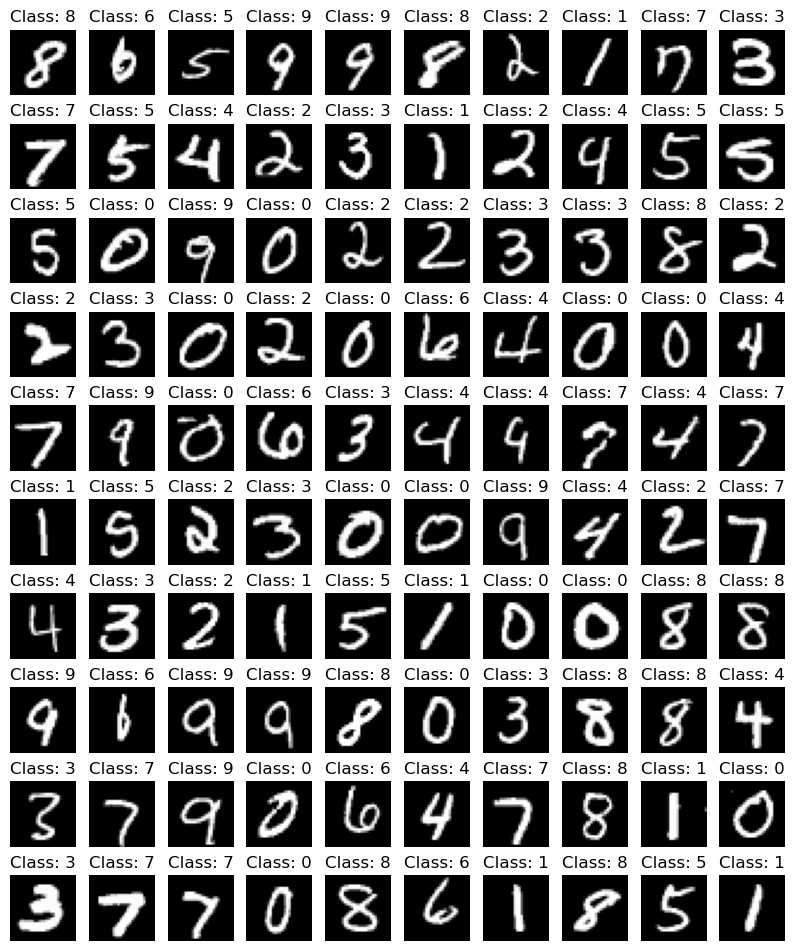

In [9]:
# 미니배치 데이터 중 100개 이미지만 출력해보기
import matplotlib.pyplot as plt
# 주피터 노트북에서 그림을 노트북 내에 표시하도록 강제하는 명령
%matplotlib inline

plt.figure(figsize=(10, 12)) # 표시할 그림의 사이즈를 정의

X_train, y_train = next(iter(train_batchs))
for index in range(100):
    plt.subplot(10, 10, index+1) # 표시할 그림들의 행렬 및 시작위치를 정의
    plt.axis('off') # 축 off
    plt.imshow(X_train[index, :, :, :].numpy().reshape(28, 28), cmap = 'gray')
    # 미니배치 X_train을 첫번째 차원(인덱스) 기준으로 ndarray로 변환시키고 그걸 다시 (28, 28)로 reshape한다, 색깔은 gray
    plt.title('Class: ' + str(y_train[index].item()))
    
plt.show()

# 모델 정의

# BatchNorm
- nn.BatchNorm1d(C) : 텐서 형태가 (N, C) 또는 (N, C, L)인 경우 적용
  - N은 미니배치 사이즈, C는 feature의 수, L은 데이터 길이
- nn.BatchNorm2d(C) : 텐서 형태가 (N, C, H, W)인 경우 적용
  - N은 미니배치 사이즈, C는 feature의 수, H와 W는 height와 width를 의미함

In [14]:
class Layer(nn.Module): # 1개 레이어 클래스 생성
    def __init__(self, input_size, output_size, batch_norm=True, dropout=0.5): # 배치놈과 드랍아웃의 초기값 지정
        self.input_size = input_size
        self.output_size = output_size
        self.batch_norm = batch_norm
        self.dropout = dropout

        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            self.apply_regularization()
        )

    def apply_regularization(self): # 배치놈과 드랍아웃 중 어떤것을 쓸지에 대한 함수 정의
        if self.batch_norm:
            return nn.BatchNorm1d(self.output_size) # 앞단의 linear Layer 출력이 BatchNorm으로 들어가는 입력
        else:
            return nn.Dropout(self.dropout)

    def forward(self, x):
        return self.layer(x)

# 별도 Layer 클래스 기반, 모델 정의

In [15]:
class DNNModel(nn.Module):
    def __init__(self, input_size, output_size, batch_norm=True, dropout=0.5):
        super().__init__()

        self.layers = nn.Sequential(
            Layer(input_size, 256, batch_norm, dropout),
            Layer(256, 256, batch_norm, dropout),
            Layer(256, 128, batch_norm, dropout),
            nn.Linear(128, output_size), # 마지막 출력은 결과이기 때문에 배치놈이나 드랍아웃을 적용하지 않음
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        return self.layers(x)

# input, output, model 설정

In [22]:
input_size = 28*28
output_size = 10
# model = DNNModel(input_size, output_size)
model = DNNModel(input_size, output_size, False, 0.2)
model # 모델 객체 출력

DNNModel(
  (layers): Sequential(
    (0): Layer(
      (layer): Sequential(
        (0): Linear(in_features=784, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Dropout(p=0.2, inplace=False)
      )
    )
    (1): Layer(
      (layer): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Dropout(p=0.2, inplace=False)
      )
    )
    (2): Layer(
      (layer): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Dropout(p=0.2, inplace=False)
      )
    )
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): LogSoftmax(dim=-1)
  )
)

# loss function, optimizer 설정

In [23]:
loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training Code 템플릿

In [24]:
def train_model(model, early_stop, nb_epochs, progress_interval):
    train_losses, valid_losses, lowest_loss = list(), list(), np.inf

    for epoch in range(nb_epochs):
        train_loss, valid_loss = 0, 0

        # train model
        model.train() # prepare model for training
        for x_minibatch, y_minibatch in train_batchs:
            y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
            loss = loss_func(y_minibatch_pred, y_minibatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_batchs)
        train_losses.append(train_loss)

        # validate model
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in va_batchs:
                y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
                loss = loss_func(y_minibatch_pred, y_minibatch)
                valid_loss += loss.item()
    
        valid_loss = valid_loss / len(va_batchs)
        valid_losses.append(valid_loss)
    
        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
        else:
            if (early_stop > 0) and lowest_epoch + early_stop < epoch:
                print("Early Stopped", epoch, "epochs")
                break
    
        if (epoch % progress_interval) == 0:
            print(train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)

    model.load_state_dict(best_model)
    return model, lowest_loss, train_losses, valid_losses

# 훈련 실행

In [25]:
nb_epochs = 30
progress_interval = 3
early_stop = 10

model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)

0.4380734710494677 0.15780336766483935 0.15780336766483935 0 0
0.09466438030699889 0.08571283904677059 0.08571283904677059 3 3
0.05972152954464158 0.07475473409260999 0.07475473409260999 6 6
0.04155824662931264 0.08614555444132457 0.07212365320091077 7 9
0.03507923554070294 0.07799049224357735 0.07212365320091077 7 12
0.030620812065899373 0.07668792454406936 0.07212365320091077 7 15
Early Stopped 18 epochs


# 테스트셋 기반 Evaluation

In [26]:
test_loss = 0
correct = 0
wrong_samples, wrong_preds, actual_preds = list(), list(), list()

model.eval()
with torch.no_grad():
    for x_minibatch, y_minibatch in test_batchs:
        y_test_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
        test_loss += loss_func(y_test_pred, y_minibatch)
        pred = torch.argmax(y_test_pred, dim=1)
        correct += pred.eq(y_minibatch).sum().item()

        wrong_idx = pred.ne(y_minibatch).nonzero()[:, 0].numpy().tolist()
        for index in wrong_idx:
            wrong_samples.append(x_minibatch[index])
            wrong_preds.append(pred[index])
            actual_preds.append(y_minibatch[index])

test_loss /= len(test_batchs.dataset)
print('Average Test Loss: {:.4f}'.format(test_loss))
print('Accuracy: {}/{} ({:.2f}%)'.format(correct, len(test_batchs.dataset), 100*correct/len(test_batchs.dataset)))

Average Test Loss: 0.0006
Accuracy: 9793/10000 (97.93%)
